In [1]:
%matplotlib inline
import carmcmc as cm
import numpy as np
import matplotlib.pyplot as plt

# set the CARMA model parameters
sigmay = 2.3  # dispersion in the time series
p = 5  # order of the AR polynomial
mu = 17.0  # mean of the time series
qpo_width = np.array([1.0/100.0, 1.0/300.0, 1.0/200.0])  # widths of of Lorentzian components
qpo_cent = np.array([1.0/5.0, 1.0/25.0])  # centroids of Lorentzian components
ar_roots = cm.get_ar_roots(qpo_width, qpo_cent) # compute the roots r_k from the Lorentzian function parameters
ar_coefs = np.poly(ar_roots)
ma_coefs = np.array([1.0, 4.5, 1.25, 0.0, 0.0])
# convert CARMA model variance to variance in the driving white noise
sigsqr = sigmay ** 2 / cm.carma_variance(1.0, ar_roots, ma_coefs=ma_coefs)  # ca

Text(0,0.5,'magnitude')

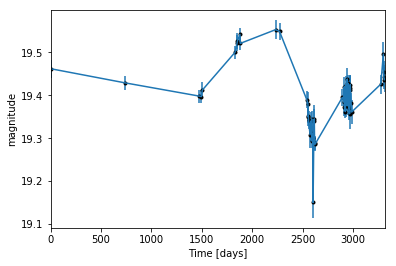

In [2]:
data = np.genfromtxt('LC_R_18822.dat')
juldate = data[:,0]  # time is given by the julian date
t = juldate - juldate.min()  # set first time value to zero for convenience. units of t are days.
y = data[:,1]  # i-band magnitudes
yerr = data[:,2]  # standard deviation in the measurement noise

plt.errorbar(t, y, yerr=yerr)
plt.plot(t, y, 'k.')
plt.xlim(t.min(), t.max())
plt.xlabel('Time [days]')
plt.ylabel('magnitude')

In [3]:
model = cm.CarmaModel(t, y, yerr, p=4, q=1)

In [4]:
%%capture capt
sample = model.run_mcmc(20000)

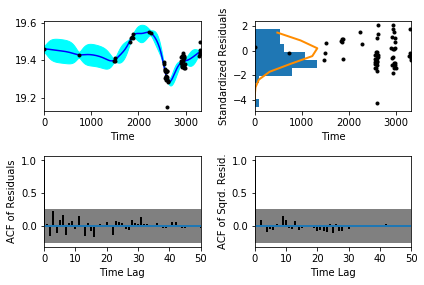

In [5]:
sample.assess_fit()

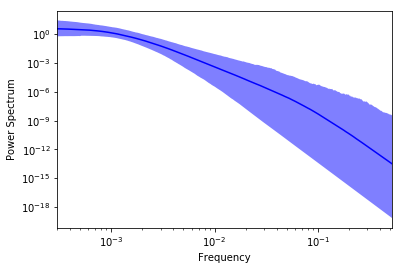

In [6]:
psd_low, psd_hi, psd_mid, frequencies = sample.plot_power_spectrum(percentile=95.0, nsamples=5000)

In [7]:
dt = t[1:] - t[:-1]
noise_level = 2.0 * np.mean(dt) * np.mean(yerr ** 2)

Text(0.000376389,0.0411911,'Nivel de ruido')

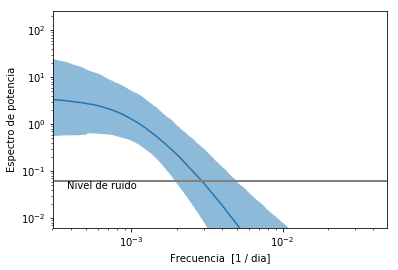

In [8]:
plt.loglog(frequencies, psd_mid)
plt.fill_between(frequencies, psd_hi, y2=psd_low, alpha=0.5)
plt.loglog(frequencies, np.ones(frequencies.size) * noise_level, color='grey', lw=2)
plt.ylim(noise_level / 10.0, plt.ylim()[1])
plt.xlim(frequencies.min(), frequencies[psd_hi > noise_level].max() * 10.0)
plt.ylabel('Espectro de potencia')
plt.xlabel('Frecuencia  [1 / dia]')
plt.annotate("Nivel de ruido", (1.25* plt.xlim()[0], noise_level / 1.5))

Text(0.5,1,'Forecasting, Expected Value')

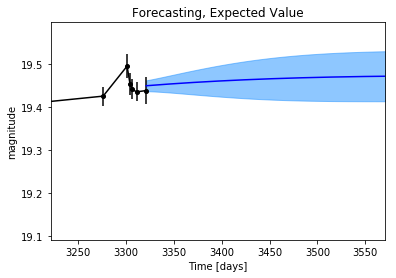

In [9]:
tpredict = t.max() + np.linspace(0.0, 250.0, 250)
ypredict, yp_var = sample.predict(tpredict)
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
plt.fill_between(tpredict, ypredict+np.sqrt(yp_var), y2=ypredict-np.sqrt(yp_var), color='DodgerBlue', alpha=0.5)
plt.plot(tpredict, ypredict, 'b-')
plt.xlim(tpredict.min() - 100, tpredict.max())
plt.xlabel('Time [days]')
plt.ylabel('magnitude')
plt.title('Forecasting, Expected Value')

Text(0.5,1,'Forecasting, Simulated Paths')

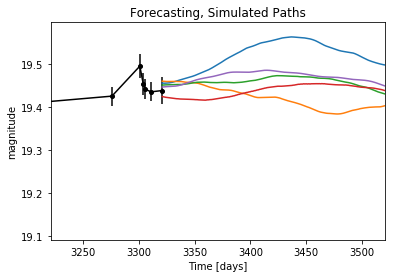

In [10]:
tpredict = t.max() + np.linspace(0.0, 200.0, 250)
npaths = 5
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
for i in range(npaths):
    ysim = sample.simulate(tpredict, bestfit='random')  # use a random draw of the CARMA parameters from its posterior
    plt.plot(tpredict, ysim)
plt.xlabel('Time [days]')
plt.ylabel('magnitude')
plt.xlim(tpredict.min()-100, tpredict.max())
plt.title('Forecasting, Simulated Paths')

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


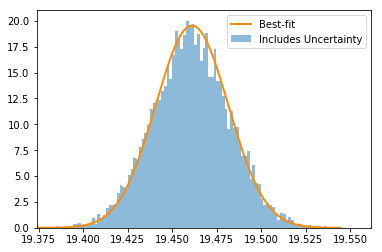

In [11]:
tpredict = 10.0
nsim = 10000
ysim = np.zeros(nsim)
for i in range(nsim):
    ysim[i] = sample.simulate(tpredict, bestfit='random')
yhat, yhvar = sample.predict(tpredict)
plt.hist(ysim, bins=100, alpha=0.5, histtype='stepfilled', normed=True, label='I')
ymin, ymax = plt.xlim()
ygrid = np.linspace(ymin, ymax, 200)
predictive_pdf = 1.0 / np.sqrt(2.0 * np.pi * yhvar) * np.exp(-0.5 * (ygrid - yhat) ** 2 / yhvar)
plt.plot(ygrid, predictive_pdf, color='DarkOrange', lw=2, label='Best-fit')
plt.xlim(ymin, ymax + 0.1 * (ymax - ymin))
plt.legend(loc='upper right')

Text(0.5,1,'Interpolacion, camino simulado')

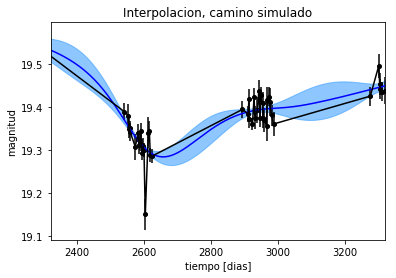

In [12]:
tinterp = t.max() - 1000 + np.linspace(0.0, 1000.0, 500)
ypredict, yp_var = sample.predict(tinterp)
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
plt.fill_between(tinterp, ypredict+np.sqrt(yp_var), y2=ypredict-np.sqrt(yp_var), color='DodgerBlue', alpha=0.5)
plt.plot(tinterp, ypredict, 'b-')
plt.xlabel('tiempo [dias]')
plt.ylabel('magnitud')
plt.xlim(tinterp.min(), tinterp.max())
plt.title('Interpolacion, camino simulado')

Text(0.5,1,'Interpolacion, camino simulado')

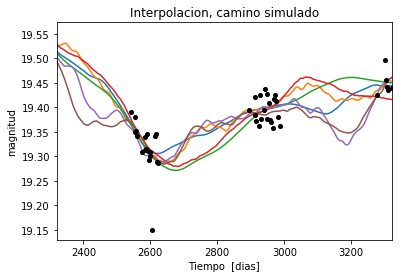

In [13]:
tinterp = t.max() - 1000 + np.linspace(0.0, 1000.0, 500)
npaths = 6
for i in range(npaths):
    ysim = sample.simulate(tinterp, bestfit='random')
    plt.plot(tinterp, ysim)
plt.plot(t, y, 'ko', ms=4)
plt.xlabel('Tiempo  [dias]')
plt.ylabel('magnitud')
plt.xlim(tinterp.min(), tinterp.max())
plt.title('Interpolacion, camino simulado')

In [14]:
sample.parameters

['quad_coefs',
 'logpost',
 'ar_coefs',
 'mu',
 'psd_centroid',
 'loglik',
 'psd_width',
 'var',
 'measerr_scale',
 'sigma',
 'ma_coefs',
 'ar_roots']

In [15]:
centroid_samples = sample.get_samples('psd_centroid')
centroid_samples.shape

(20000, 4)

In [16]:
sample.posterior_summaries('psd_centroid')

Calculating effective number of samples
Posterior summary for parameter psd_centroid  element 0
----------------------------------------------
Effective number of independent samples: 645.36293634
Median: 0.00168862195639
Standard deviation: 0.222983797844
68% credibility interval: [ 0.          0.22492465]
95% credibility interval: [ 0.          0.85311371]
99% credibility interval: [ 0.         0.9993997]
Posterior summary for parameter psd_centroid  element 1
----------------------------------------------
Effective number of independent samples: 645.36293634
Median: 0.00168862195639
Standard deviation: 0.222983797844
68% credibility interval: [ 0.          0.22492465]
95% credibility interval: [ 0.          0.85311371]
99% credibility interval: [ 0.         0.9993997]
Posterior summary for parameter psd_centroid  element 2
----------------------------------------------
Effective number of independent samples: 1284.30734905
Median: 0.0
Standard deviation: 0.000444030832145
68% credib

Plotting parameter summary


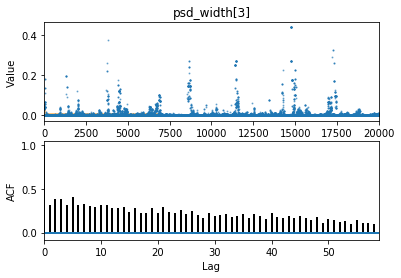

In [17]:
sample.plot_parameter('psd_width', 3, doShow=True)

In [18]:
centroid_samples = sample.get_samples('logpost')
centroid_samples.shape

(20000, 1)

In [19]:
sample.posterior_summaries('logpost')

Calculating effective number of samples
Posterior summary for parameter logpost  element 0
----------------------------------------------
Effective number of independent samples: 2504.08633421
Median: 136.316663897
Standard deviation: 1.71245612712
68% credibility interval: [ 134.41003061  137.63431968]
95% credibility interval: [ 131.86573615  138.44270902]
99% credibility interval: [ 129.93376448  138.99436795]


In [20]:
centroid_samples = sample.get_samples('ar_coefs')
centroid_samples.shape

(20000, 5)

In [21]:
sample.posterior_summaries('ar_coefs')

Calculating effective number of samples
Posterior summary for parameter ar_coefs  element 0
----------------------------------------------
Effective number of independent samples: nan
Median: 1.0
Standard deviation: 0.0
68% credibility interval: [ 1.  1.]
95% credibility interval: [ 1.  1.]
99% credibility interval: [ 1.  1.]
Posterior summary for parameter ar_coefs  element 1
----------------------------------------------
Effective number of independent samples: 746.693603244
Median: 0.514266333895
Standard deviation: 2.04749250945
68% credibility interval: [ 0.03570458  3.60597665]
95% credibility interval: [ 0.01182626  6.81261521]
99% credibility interval: [  9.22264287e-03   9.69526160e+00]
Posterior summary for parameter ar_coefs  element 2
----------------------------------------------
Effective number of independent samples: 684.313950281
Median: 0.182976334413
Standard deviation: 8.05979549396
68% credibility interval: [ 0.00751827  4.37878779]
95% credibility interval: [  4.1

In [22]:
centroid_samples = sample.get_samples('ma_coefs')
centroid_samples.shape

(20000, 2)

In [23]:
sample.posterior_summaries('ma_coefs')

Calculating effective number of samples
Posterior summary for parameter ma_coefs  element 0
----------------------------------------------
Effective number of independent samples: nan
Median: 1.0
Standard deviation: 0.0
68% credibility interval: [ 1.  1.]
95% credibility interval: [ 1.  1.]
99% credibility interval: [ 1.  1.]
Posterior summary for parameter ma_coefs  element 1
----------------------------------------------
Effective number of independent samples: 1000.93323877
Median: 3.22801633456e-50
Standard deviation: 6.29389692034e+68
68% credibility interval: [  4.05231108e-126   4.90474282e-015]
95% credibility interval: [  5.85282157e-291   3.96058482e+017]
99% credibility interval: [  2.64020034e-300   3.61661873e+042]


In [24]:
centroid_samples = sample.get_samples('mu')
centroid_samples.shape

(20000, 1)

In [25]:
sample.posterior_summaries('mu')

Calculating effective number of samples
Posterior summary for parameter mu  element 0
----------------------------------------------
Effective number of independent samples: 2917.09948786
Median: 19.4409593745
Standard deviation: 0.0470977300119
68% credibility interval: [ 19.4029904   19.47678914]
95% credibility interval: [ 19.34629554  19.53235013]
99% credibility interval: [ 19.27933423  19.59793898]


In [26]:
centroid_samples = sample.get_samples('psd_centroid')
centroid_samples.shape

(20000, 4)

In [27]:
sample.posterior_summaries('psd_centroid')

Calculating effective number of samples
Posterior summary for parameter psd_centroid  element 0
----------------------------------------------
Effective number of independent samples: 645.36293634
Median: 0.00168862195639
Standard deviation: 0.222983797844
68% credibility interval: [ 0.          0.22492465]
95% credibility interval: [ 0.          0.85311371]
99% credibility interval: [ 0.         0.9993997]
Posterior summary for parameter psd_centroid  element 1
----------------------------------------------
Effective number of independent samples: 645.36293634
Median: 0.00168862195639
Standard deviation: 0.222983797844
68% credibility interval: [ 0.          0.22492465]
95% credibility interval: [ 0.          0.85311371]
99% credibility interval: [ 0.         0.9993997]
Posterior summary for parameter psd_centroid  element 2
----------------------------------------------
Effective number of independent samples: 1284.30734905
Median: 0.0
Standard deviation: 0.000444030832145
68% credib

In [28]:
centroid_samples = sample.get_samples('loglik')
centroid_samples.shape

(20000, 1)

In [29]:
sample.posterior_summaries('loglik')

Calculating effective number of samples
Posterior summary for parameter loglik  element 0
----------------------------------------------
Effective number of independent samples: 2504.08633421
Median: 136.316663897
Standard deviation: 1.71245612712
68% credibility interval: [ 134.41003061  137.63431968]
95% credibility interval: [ 131.86573615  138.44270902]
99% credibility interval: [ 129.93376448  138.99436795]


In [30]:
centroid_samples = sample.get_samples('psd_width')
centroid_samples.shape

(20000, 4)

In [31]:
sample.posterior_summaries('psd_width')

Calculating effective number of samples
Posterior summary for parameter psd_width  element 0
----------------------------------------------
Effective number of independent samples: 529.896923376
Median: 0.00460283798176
Standard deviation: 0.189736261096
68% credibility interval: [ 0.00064909  0.15300473]
95% credibility interval: [  3.44408178e-04   7.46976337e-01]
99% credibility interval: [  3.09660854e-04   9.86394055e-01]
Posterior summary for parameter psd_width  element 1
----------------------------------------------
Effective number of independent samples: 294.74253104
Median: 0.00127992791958
Standard deviation: 0.0817180225865
68% credibility interval: [ 0.00048902  0.01463217]
95% credibility interval: [ 0.00032662  0.24202833]
99% credibility interval: [  3.05993107e-04   6.35336533e-01]
Posterior summary for parameter psd_width  element 2
----------------------------------------------
Effective number of independent samples: 496.109359183
Median: 0.00853237486054
Standard

In [32]:
centroid_samples = sample.get_samples('var')
centroid_samples.shape

(20000, 1)

In [33]:
sample.posterior_summaries('var')

Calculating effective number of samples
Posterior summary for parameter var  element 0
----------------------------------------------
Effective number of independent samples: 2380.63592121
Median: 0.00772616904085
Standard deviation: 0.0108255504237
68% credibility interval: [ 0.00435851  0.01599893]
95% credibility interval: [ 0.00277459  0.03787581]
99% credibility interval: [ 0.00209812  0.06891092]


In [34]:
centroid_samples = sample.get_samples('measerr_scale')
centroid_samples.shape

(20000, 1)

In [35]:
sample.posterior_summaries('measerr_scale')

Calculating effective number of samples
Posterior summary for parameter measerr_scale  element 0
----------------------------------------------
Effective number of independent samples: 3836.50943651
Median: 1.1931557983
Standard deviation: 0.175998184951
68% credibility interval: [ 1.0359388   1.38210926]
95% credibility interval: [ 0.90858406  1.59408034]
99% credibility interval: [ 0.84338944  1.76379775]


In [36]:
centroid_samples = sample.get_samples('sigma')
centroid_samples.shape

(20000, 1)

In [37]:
sample.posterior_summaries('sigma')

Calculating effective number of samples
Posterior summary for parameter sigma  element 0
----------------------------------------------
Effective number of independent samples: 2737.45389674
Median: 1.81291100329e-05
Standard deviation: 0.0171589639255
68% credibility interval: [  4.31274621e-07   5.55498330e-04]
95% credibility interval: [  3.06998097e-24   5.26775876e-03]
99% credibility interval: [  4.38295173e-48   7.08320108e-02]


In [38]:
centroid_samples = sample.get_samples('ar_roots')
centroid_samples.shape

(20000, 4)

In [39]:
sample.posterior_summaries('ar_roots')

Calculating effective number of samples
Posterior summary for parameter ar_roots  element 0
----------------------------------------------
Effective number of independent samples: 529.896923376
Median: (-0.0289204839783-0.558580322698j)
Standard deviation: 1.83960703021
68% credibility interval: [-0.96135708+0.j        -0.00407834-0.0021837j]
95% credibility interval: [ -4.69339075e+00+0.j          -2.16398041e-03-0.00434833j]
99% credibility interval: [ -6.19769663e+00+0.j        -1.94565653e-03-0.001916j]
Posterior summary for parameter ar_roots  element 1
----------------------------------------------
Effective number of independent samples: 294.74253104
Median: (-0.00804202429856+0.0842472571991j)
Standard deviation: 1.49216866651
68% credibility interval: [-0.09193662+1.46159791j -0.00307263+0.92666811j]
95% credibility interval: [-1.52070886+1.79997442j -0.00205224+0.00282779j]
99% credibility interval: [ -3.99193717e+00 +6.27819823e+00j  -1.92261139e-03 +6.03334170e-03j]
Posteri

Plotting 2d PDF w KDE


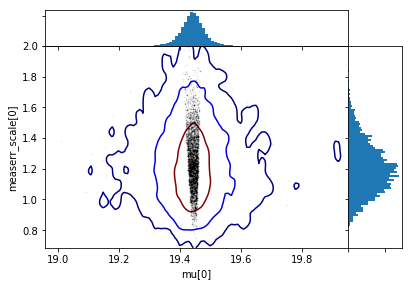

In [40]:
sample.plot_2dkde('mu', 'measerr_scale', doShow=True)